(EN)
In this project ,you'll be able two versions  one in french and  one in English , I speak fluently French , my English isn't perfect but i can share my Knowledge in this language also,i've used the ai for translate some parts. 
The topic of this project is 100% the behave.
Enjoy your reading.

(VF)
Dans ce projet, vous trouverez deux versions  une en français et une en anglais.
Je parle couramment le français, et même si mon anglais n’est pas parfait, je souhaite partager mes connaissances également dans cette langue.
Le sujet de ce projet porte à 100 % sur le comportement.
Bonne lecture !

Librairies imports 

In [33]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap 
from sklearn.feature_selection import mutual_info_classif
from lightgbm import LGBMClassifier


Dataset Files 

In [34]:
train=pd.read_csv(r"/workspaces/Space-Titinac-on-kaggle-/train.csv")
test=pd.read_csv(r"/workspaces/Space-Titinac-on-kaggle-/test.csv")


Data analysis
Goals:
 1)Understand the context and  meaning  of  the features
 2)Identify  string (catgorical) columns

In [35]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Note: 
-The target is a transport_related variable.Based on the features and my background in humanities, I can say the context and meaning of this data relate to behaviors 
-We can examine the string (categorical) columns and separate them by character or by space.

3)Check if the columns have  only categories or  a single values 

In [36]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

Note:
-We can see  that none of the  columns have only a single value or a single category.
Therefore,the future model will  be able to generalize across several columns.


4)Check for repeated rows 

In [37]:
train.duplicated().sum()

np.int64(0)

Interpretation:
There are no repeated rows in the dataset 

5)Identify the non-numericals columns with many  categories 

In [38]:
col_others=train.select_dtypes(exclude=np.number).columns
#We can use the nunique() function  again 
train[col_others].nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
Transported       2
dtype: int64

6) Separate the features and the target to avoid data leakage — 
Version (VF)
Séparer les caractéristiques (features) et la variable cible afin d’éviter toute fuite de données. 

In [39]:

x_train=train.drop("Transported",axis=1)
y_train=train["Transported"]
x_test=test.copy()
test_ids=test["PassengerId"].copy()


7)Creation of new string columns 

 Création de nouvelles colonnes de type chaîne de caractères.

In [40]:

#In x_train
x_train[["group","id"]] =x_train["PassengerId"].str.split("_", expand=True)
x_train[["firstname","lastname"]] = x_train["Name"].str.split(" ", expand=True)
x_train[["deck","num","side"]] =x_train["Cabin"].str.split("/", expand=True)

#In x_test
x_test[["group","id"]] =x_test["PassengerId"].str.split("_", expand=True)
x_test[["firstname","lastname"]] = x_test["Name"].str.split(" ", expand=True)
x_test[["deck","num","side"]] =x_test["Cabin"].str.split("/", expand=True)


8)Manage the NaN values in the smartest possible way 

 Gérer les valeurs manquantes de la manière la plus intelligente possible.


Explanation:
We know that if we belong to the same family, we basically share the same lastname 
If we are from the same family, we come from the same planet 
Then, I used this column to predict some missing values in the “HomePlanet”

Explication:(VF)
Nous savons que si nous appartenons à la même famille, nous partageons essentiellement le même nom de famille.
Si nous faisons partie de la même famille, nous venons de la même planète.
Alors , j'ai utilisé la colonne lastname pour prédire certaines valeurs manquantes de la colonne "HomePlanet".


In [41]:
lastname_dict=x_train[x_train["HomePlanet"].notna()].groupby("lastname")["HomePlanet"].first()

English version:
This function collects only the rows from the training data where the HomePlanet values are not missing. 
In this new dataset, I gathered the HomePlanet values based on the lastname column for rows that are not NaN, since the groupby function automatically ignores missing values by default.
 Then, I used this mapping to fill the missing values in the HomePlanet column of the training data.

Version française :
Cette fonction récupère uniquement les lignes de l’ensemble d’entraînement où la colonne HomePlanet n’est pas manquante. Dans ce nouveau sous-ensemble de données, j’ai rassemblé les valeurs de la colonne HomePlanet en me basant sur la colonne lastname pour les lignes qui ne sont pas NaN, car la fonction groupby ignore par défaut les valeurs manquantes. Ensuite, j’ai utilisé cette correspondance pour remplir les valeurs manquantes de la colonne HomePlanet dans les données d’entraînement


In [42]:
x_train["HomePlanet"]=x_train["HomePlanet"].fillna(x_train["lastname"].map(lastname_dict))


English version:
I’m going to apply this rule to my x_test data. However, if I only use the names present in x_test to fill the missing values in the HomePlanet column, I’ll face a limitation: when a name exists in both x_train and x_test, but in x_test that name has only missing values for HomePlanet, my current method won’t be able to handle it. Therefore, I chose the following approach instead.

Version française :
Je vais appliquer cette règle à mes données x_test. Cependant, si je me base uniquement sur les noms présents dans x_test pour remplir les valeurs manquantes de la colonne HomePlanet, je serai confronté à une limite : lorsqu’un nom existe à la fois dans x_train et x_test, mais que dans x_test ce nom ne contient que des valeurs manquantes dans HomePlanet, ma méthode actuelle ne peut pas le résoudre. J’ai donc choisi d’adopter l’approche suivante.

In [43]:

x_test["HomePlanet"]= x_test["HomePlanet"].fillna(x_train["lastname"].map(lastname_dict))

English version:
This handles the case where a lastname exists only in the x_test data.
Version française :
Cela concerne le cas où un nom de famille n’existe que dans les données x_test.

In [44]:
lastname_dict_x_test=x_test[x_test["HomePlanet"].notna()].groupby("lastname")["HomePlanet"].first()
x_test["HomePlanet"]=x_test["HomePlanet"].fillna(x_test["lastname"].map(lastname_dict_x_test))
print(x_train.isna().sum())
print(x_test.isna().sum())

PassengerId       0
HomePlanet       15
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
group             0
id                0
firstname       200
lastname        200
deck            199
num             199
side            199
dtype: int64
PassengerId       0
HomePlanet        0
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
group             0
id                0
firstname        94
lastname         94
deck            100
num             100
side            100
dtype: int64


English version:
Afterwards, I reasoned that if a person is sleeping, they can't spend on shopping. I used a proof by contradiction to verify my hypothesis.
Version française :
Ensuite, je me suis dit que si une personne dort, elle ne peut pas dépenser pour le shopping. J’ai utilisé un raisonnement par l’absurde pour vérifier mon hypothèse.

In [45]:
x_train[(x_train["ShoppingMall"]>0) & (x_train["CryoSleep"]==True)]


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,group,id,firstname,lastname,deck,num,side


English version:
I wanted to go deeper. I noticed that many rows in the columns 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', and 'VRDeck' were equal to zero. I understood this, deduced it, and then verified it using a proof by contradiction.

Version française :
Je voulais approfondir. J’ai remarqué que de nombreuses lignes dans les colonnes 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa' et 'VRDeck' étaient égales à zéro. J’ai compris cela, je l’ai déduit et je l’ai  ensuite vérifié par raisonnement  absurde.

In [46]:
x_train[((x_train["ShoppingMall"]>0)  | (x_train["FoodCourt"]>0) |(x_train['RoomService']>0) | (x_train['Spa']>0) | (x_train['VRDeck']>0)) & (x_train["CryoSleep"]==True)]


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,group,id,firstname,lastname,deck,num,side


English version:
As you can see, there are no rows that contradict my hypothesis; it is consistent.
Therefore, I replaced only the NaN values for the people who are asleep with 0.
Version française :
Comme vous pouvez le voir, aucune ligne ne contredit mon hypothèse ; elle est cohérente.
J’ai donc remplacé uniquement les valeurs NaN des personnes endormies  par 0 dans la colonnes CryoSleep.

In [47]:
col_num=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in col_num:
    x_train.loc[x_train["CryoSleep"]==True,col]=x_train.loc[x_train["CryoSleep"]==True,col].fillna(0)

A)
FR : Pour obtenir cette règle, je me suis basé uniquement sur le x_train.
EN : To obtain this rule, I based it only on x_train.

In [48]:
col_num=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

B)
FR : Nous ne nous basons pas sur les personnes elles-mêmes, mais sur le fait qu’elles dorment ou non ; c’est la raison pour laquelle je n’ai pas utilisé les données de train.
EN : We do not base it on the people themselves, but on whether they sleep or not; this is the reason why I did not use the train data.


In [49]:
for col in col_num:
    x_test.loc[x_test["CryoSleep"]==True,col]=x_test.loc[x_test["CryoSleep"]==True,col].fillna(0)

x_test["CryoSleep"].isna().sum()

np.int64(93)

C)
FR : Bien sûr, j’ai exploré un peu le x_train, j’ai constaté certains faits, puis j’ai vérifié pour chaque cas par l’absurde mon hypothèse comme expliqué ci-dessus. Je vous laisse voir les résultats.
EN : Of course, I explored x_train a bit, observed some facts, and then checked each case by contradiction against my hypothesis as explained above. I let you see the results.


In [50]:
x_train[((x_train["deck"]=="A") | (x_train["deck"]=="B") | (x_train["deck"]=="C") | (x_train["deck"]=="T")) & (x_train["HomePlanet"]!="Europa")]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,group,id,firstname,lastname,deck,num,side
234,0251_01,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,0251,01,Diphah,Amsive,C,11,S
807,0853_01,NaN,True,A/9/S,55 Cancri e,38.0,False,0.0,0.0,0.0,0.0,0.0,Hamelik Ageurante,0853,01,Hamelik,Ageurante,A,9,S


D)
FR : Application de l’hypothèse.
EN : Application of the hypothesis.


In [51]:
x_train.loc[((x_train["deck"]=="A")| (x_train["deck"]=="B") | (x_train["deck"]=="C") | (x_train["deck"]=="T")),"HomePlanet"]=x_train.loc[((x_train["deck"]=="A")| (x_train["deck"]=="B") | (x_train["deck"]=="C") | (x_train["deck"]=="T")),"HomePlanet"].fillna("Europa")

In [52]:
x_test.loc[((x_test["deck"]=="A")| (x_test["deck"]=="B") | (x_test["deck"]=="C") | (x_test["deck"]=="T")),"HomePlanet"]=x_test.loc[((x_test["deck"]=="A")| (x_test["deck"]=="B") | (x_test["deck"]=="C") | (x_test["deck"]=="T")),"HomePlanet"].fillna("Europa")

E)
FR : Je me suis basé uniquement sur le x_train pour établir cette hypothèse.
EN : I based myself only on x_train to establish this hypothesis.
F)
FR : Vérification de l’hypothèse.
EN : Hypothesis check.

In [53]:
x_train[(x_train["deck"]=="G")  & (x_train["HomePlanet"]!="Earth")]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,group,id,firstname,lastname,deck,num,side
1855,1978_01,NaN,True,G/311/S,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,NaN,1978,01,NaN,NaN,G,311,S
6644,7006_01,NaN,True,G/1142/S,PSO J318.5-22,16.0,False,0.0,0.0,0.0,0.0,0.0,Tammyl Fuenton,7006,01,Tammyl,Fuenton,G,1142,S
7211,7703_02,NaN,True,G/1251/S,TRAPPIST-1e,13.0,False,0.0,0.0,0.0,0.0,0.0,NaN,7703,02,NaN,NaN,G,1251,S


G)
FR : Utilisation de l’hypothèse.
EN : Utilization of the hypothesis.


In [54]:
x_train.loc[(x_train["deck"]=="G"),"HomePlanet"]=x_train.loc[(x_train["deck"]=="G"),"HomePlanet"].fillna("Earth")

x_test.loc[(x_test["deck"]=="G"),"HomePlanet"]=x_test.loc[(x_test["deck"]=="G"),"HomePlanet"].fillna("Earth")

x_train["HomePlanet"].isna().sum()
print(x_test["HomePlanet"].isna().sum())

0


H)
FR : Comme vous pouvez le voir, je continue d’appliquer la même méthode sur le x_test, même si la colonne HomePlanet dans x_test n’a pas de valeurs NaN. Je veux le meilleur modèle pour la généralisation et non seulement pour performer sur ces données.
EN : As you can see, I continue to apply the same method on x_test, even if the HomePlanet column in x_test has no NaN values. I want the best model for generalization, not just to perform on this data.


I)
FR : Un point très important : toutes les personnes dans un même groupe viennent de la même planète.

EN : A very important point: all people in the same group come from the same planet.


In [55]:
check = x_train.groupby("group")["HomePlanet"].nunique()
check[check > 1]

Series([], Name: HomePlanet, dtype: int64)

J)
FR : Comme le résultat est vide, mon hypothèse est confirmée.
EN : Since the result is empty, my hypothesis is confirmed.


K)
FR : Application de l’hypothèse.
EN : Application of the hypothesis.


In [56]:

group_dict=x_train.groupby("group")["HomePlanet"].first()
x_train['HomePlanet'] = x_train['HomePlanet'].fillna(x_train["group"].map(group_dict))

x_train["HomePlanet"].isna().sum()

np.int64(8)

L)
FR : S’il reste encore des NaN dans HomePlanet, cela concerne soit les personnes seules, soit les groupes dont toutes les personnes ont des valeurs manquantes dans HomePlanet. Application sur x_test.
EN : If there are still NaN values in HomePlanet, it concerns either lonely individuals or groups where all people have missing values in HomePlanet. Applied on x_test.


In [57]:
x_test["HomePlanet"]=x_test["HomePlanet"].fillna(x_train["group"].map(group_dict))

group_dict_x_test=x_test.groupby("group")["HomePlanet"].first()

x_test["HomePlanet"]=x_test["HomePlanet"].fillna(x_test["group"].map(group_dict))


M)
FR : Vérification de l’hypothèse.
EN : Check hypothesis.

In [58]:
x_train[(x_train["HomePlanet"]=="Earth") & (x_train["VIP"]==True)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,group,id,firstname,lastname,deck,num,side


N_1)
FR : Comme je n’ai presque plus de NaN dans cette colonne, c’est le bon moment pour utiliser cette colonne pour gérer les valeurs manquantes des autres colonnes.

EN : Since there are almost no NaN values in this column, this is the right moment to use it to handle missing values in other columns.

N_2)
FR : Les terriens ne sont jamais VIP.

EN : Earthlings are never VIP.


In [59]:
x_train.loc[x_train["HomePlanet"]=="Earth","VIP"]=x_train.loc[x_train["HomePlanet"]=="Earth","VIP"].fillna(False)

/tmp/ipykernel_24490/2961748819.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_train.loc[x_train["HomePlanet"]=="Earth","VIP"]=x_train.loc[x_train["HomePlanet"]=="Earth","VIP"].fillna(False)


O)
FR : Ici, le résultat ne dépend pas de la personne mais du lieu d’où elle vient, je n’ai donc pas besoin d’utiliser x_train pour prédire les valeurs manquantes pour le données de test.
EN : Here, the result does not depend on the person but on where they come from, so I don’t need to use x_train to predict missing values for the test data.


In [60]:
x_test.loc[x_test["HomePlanet"]=="Earth","VIP"]=x_test.loc[x_test["HomePlanet"]=="Earth","VIP"].fillna(False)

/tmp/ipykernel_24490/3222737580.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_test.loc[x_test["HomePlanet"]=="Earth","VIP"]=x_test.loc[x_test["HomePlanet"]=="Earth","VIP"].fillna(False)


P)
FR : Vérification de l’hypothèse : si vous dépensez, alors vous ne dormez pas.

EN : Check the hypothesis: if you spend, then you do not sleep.


In [61]:

x_train[((x_train["RoomService"]>0) |(x_train["FoodCourt"]>0) |(x_train["ShoppingMall"]>0) | (x_train["Spa"]>0) | (x_train["VRDeck"]>0)) & (x_train["CryoSleep"]==True)]



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,group,id,firstname,lastname,deck,num,side


FR : Un fait très important : dans ces données, bien que nous appartenions à la même famille, nous ne fréquentons pas toujours les mêmes lieux et nous ne nous comportons pas toujours de la même manière. Pour le moment, j’ai choisi d’appliquer uniquement les règles sûres pour toutes les données x_train et ce n’est pas fini.

EN : A very important fact: in this dataset, even though we belong to the same family, we don’t always go to the same places and do not behave the same way. For now, I chose to apply only the reliable rules for all x_train data, and it’s not finished.


In [62]:
col_num=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

x_train.loc[((x_train["RoomService"]>0) |(x_train["FoodCourt"]>0) |(x_train["ShoppingMall"]>0) | (x_train["Spa"]>0) | (x_train["VRDeck"]>0)),"CryoSleep"]=x_train.loc[((x_train["RoomService"]>0) |(x_train["FoodCourt"]>0) |(x_train["ShoppingMall"]>0) | (x_train["Spa"]>0) | (x_train["VRDeck"]>0)),"CryoSleep"].fillna(False)


/tmp/ipykernel_24490/2164048597.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_train.loc[((x_train["RoomService"]>0) |(x_train["FoodCourt"]>0) |(x_train["ShoppingMall"]>0) | (x_train["Spa"]>0) | (x_train["VRDeck"]>0)),"CryoSleep"]=x_train.loc[((x_train["RoomService"]>0) |(x_train["FoodCourt"]>0) |(x_train["ShoppingMall"]>0) | (x_train["Spa"]>0) | (x_train["VRDeck"]>0)),"CryoSleep"].fillna(False)


In [63]:
x_test.loc[((x_test["RoomService"]>0) |(x_test["FoodCourt"]>0) |(x_test["ShoppingMall"]>0) | (x_test["Spa"]>0) | (x_test["VRDeck"]>0)),"CryoSleep"]=x_test.loc[((x_test["RoomService"]>0) |(x_test["FoodCourt"]>0) |(x_test["ShoppingMall"]>0) | (x_test["Spa"]>0) | (x_test["VRDeck"]>0)),"CryoSleep"].fillna(False)

/tmp/ipykernel_24490/444151706.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_test.loc[((x_test["RoomService"]>0) |(x_test["FoodCourt"]>0) |(x_test["ShoppingMall"]>0) | (x_test["Spa"]>0) | (x_test["VRDeck"]>0)),"CryoSleep"]=x_test.loc[((x_test["RoomService"]>0) |(x_test["FoodCourt"]>0) |(x_test["ShoppingMall"]>0) | (x_test["Spa"]>0) | (x_test["VRDeck"]>0)),"CryoSleep"].fillna(False)


In [64]:
10)
FR : Maintenant, je peux concaténer les features x_train et x_test sans faire d’agrégation.
EN : Now I can concatenate the x_train and x_test features without performing any aggregation.

J’ai réinitialisé l’ancien index.

I reset the old index

SyntaxError: unmatched ')' (1310003419.py, line 1)

In [ ]:
df=pd.concat([x_train,x_test])
df.reset_index(drop=True,inplace=True)


In [ ]:
R)
FR : J’ai choisi de supprimer pour le moment toutes les colonnes avec une forte cardinalité, je les gérerai ensuite pour obtenir un meilleur résultat si elles ne sont pas redondantes avec les colonnes restantes dans le modèle.
EN : I chose to temporarily remove all columns with high cardinality; I will handle them later to get better results if they are not redundant with the remaining columns in the model.


In [ ]:
df.drop(["Name","PassengerId","Cabin","firstname","lastname","num","id","group"],axis=1,inplace=True)
        


S)
FR : Création du feature engineering et gestion des redondances. Pour trouver ces features, j’ai combiné une approche qui prend en compte à la fois la redondance et l’importance des features par rapport à la cible. J’espère que vous comprenez, je ne peux pas partager ma technique en détail ; de plus, je cherche toujours un stage rémunéré ou un emploi junior et ma seule valeur ajoutée provient de mes techniques. Pour ceux qui ne croient pas en ma capacité à trouver ces features, vous pouvez vérifier sur mes autres projets. Quand j’associe les features et la cible, la première chose qui me vient à l’esprit est le comportement humain. En situation de danger, l’humain fuit souvent ou reste au même endroit par peur. Si nous sommes occupés ou dormons, nous percevrons difficilement le danger et ne fuirons pas ; les personnes transportées auront peut-être été moins attentives ou au mauvais endroit, au mauvais moment, ou les trois simultanément. Le fait d’avoir dépensé de l’argent implique qu’on était probablement occupé lors du transport, et cette relation est également valable dans l’autre sens. Dans ce projet, ce qui nous aidera le plus à prédire est le comportement : dormir ou non, se faire plaisir ou pas. Mes features ne sont pas encore optimisées au maximum, et c’est pour cette raison que j’ai travaillé ensuite avec un seul modèle, car je compte explorer des features innovantes. Ce ne sont que des préliminaires.
EN : Creation of feature engineering and handling redundancies. To find these features, I combined an approach considering both redundancy and the importance of features relative to the target. I hope you understand; I cannot share my technique in detail. Additionally, I am still looking for a paid internship or junior position, and my only value comes from my techniques. For those who do not trust my ability to find features, you can verify in my other projects. When combining features and target, the first thing that comes to mind is human behavior. In danger, humans often flee or stay in place due to fear. If we are busy or asleep, we perceive danger less and do not flee; transported people might have been less attentive or in the wrong place, at the wrong time, or all three at once. Spending money implies we were probably busy during transportation, and this relationship also works in reverse. In this project, what will help most to predict is behavior: sleeping or not, enjoying oneself or not. My features are not yet fully optimized, which is why I later worked with a single model, planning to explore innovative features. These are only preliminary steps.


T)
FR : Comme les dépenses reflètent le comportement, c’était ma première idée.
EN : Since spending reflects behavior, this was my first idea.


In [ ]:
df["Totalspend"]=df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)



U)
FR : Les dépenses dépendent de l’âge.

EN : Spending depends on age.

In [ ]:
df["agespend"]=df["Totalspend"]+df["Age"]


V)
FR : La feature suivante a été générée automatiquement en fonction de son importance.
EN : The next feature was generated automatically based on its importance.


In [ ]:
df["deckhome"]=df["deck"].astype(str)+"_"+df["HomePlanet"].astype(str)

W)
FR : Chacune de ces features présente presque aucune redondance et est vraiment importante pour le modèle, comme vous le verrez dans le SHAP plus bas.
EN : Each of these features has almost no redundancy and is really important for the model, as you will see in SHAP below.


12)
FR : Remplacement des valeurs NaN, ce n’est pas définitif.
EN : Replacement of NaN values; this is not definitive.


In [ ]:
col_others=df.select_dtypes(include="object").columns
for k in col_others:
     df[k]=df[k].fillna("unknown")
num=df.select_dtypes(include=np.number).columns

In [ ]:
for i in num :
    df[i]=df[i].fillna(0)

14)
FR : Transformation des colonnes non numériques car le modèle LightGBM ne gère pas directement les columns de type 'object'.

EN : Transformation of non-numerical columns because the LightGBM model cannot directly handle object-type columns.


In [ ]:
for j in col_others:
    df[j]=df[j].astype("category")

15)
FR : Séparation des données.

EN : Separation of the data.


In [ ]:
x_train=df.iloc[:x_train.shape[0]]
x_test=df.iloc[x_train.shape[0]:]

I've used  Optuna for find my better hyperparameters

In [ ]:
import optuna

16)
FR : Dans ce projet, j’ai choisi un seul modèle pour observer ses limites, contrairement au projet House Price Advanced que vous verrez demain sur mon compte.
EN : In this project, I chose a single model to observe its limits, unlike the House Price Advanced project you will see tomorrow on my account.


In [ ]:
#lightgbm 

#def objective_lgb(trial): lgb_params={ 
#    "iterations":trial.suggest_int("iterations",1000,2000),
#     "depth":trial.suggest_int("depth",3,10),
#    "colsample_bytree":trial.suggest_float("colsample",0.2,1.0),
#     "subsample":trial.suggest_float("subsample",0.4,1.0), 
#     "learning_rate":trial.suggest_float("learning_rate",0.005,0.1),
#     "num_leaves":trial.suggest_int("num_leaves",20,200),
#      "bagging_freq":trial.suggest_int("bagging_freq",1,10), 
#   "metric":"AUC" 
#   }
    #entrainement du modèle 
#   lgb_model=LGBMClassifier(**lgb_params,verbose=-1)
#   lgb_model.fit(x_train,y_train)

    #Utilisation d'un KFold
#   kf=StratifiedKFold(n_splits=6,shuffle=True,random_state=42)
    






18)
FR : Le choix du nombre de splits est très important. S’il est trop grand ou trop petit, le modèle sera moins performant en généralisation. Ce nombre gère la répartition des données de train pour l’entraînement. Dans mon cas, 1/6 = 0,17 des données de train sera utilisé pour la validation locale et le reste pour l’entraînement local. L’argument shuffle aide à rendre le découpage aléatoire.

EN : The choice of number of splits is very important. If it is too big or too small, the model will generalize less effectively. This number manages the distribution of training data for training. In my case, 1/6 = 0.17 of the training data will be used for local validation, and the rest for local training. The shuffle argument helps randomize the split.

In [ ]:
#   lgb_auc=cross_val_score(lgb_model,x_train,y_train,scoring="roc_auc",cv=kf)
#   return np.mean(lgb_auc)

#Optuna
#study_lgb=optuna.create_study(direction="maximize")
#study_lgb.optimize(objective_lgb,n_trials=40)

19)
FR : Le nombre d’essais impacte également le résultat. Un résultat parfait sur la métrique locale n’est pas la même chose qu’une bonne généralisation. Le meilleur résultat avec une bonne généralisation vient avec plusieurs essais.

EN : The number of trials also impacts the result. A perfect result on the local metric is not the same as good generalization. The best result with good generalization comes from multiple trials.


In [ ]:
#best_params=study_lgb.best_params 
#best_auc_lgb=study_lgb.best_value 
#print(best_params)
#print(best_auc_lgb)

20)
FR : Après plusieurs essais, j’ai trouvé l’hyperparamètre qui généralise le mieux. J’évite de le recalculer ici car cela prendrait environ 9 minutes, même si c’est le modèle de gradient boosting le plus rapide.

EN : After many trials, I found the hyperparameter that generalizes best. I avoid recalculating it here because it would take around 9 minutes, even though it is the fastest gradient boosting model.

In [ ]:


best_params_lgb={
    'iterations': 1348,
    'depth': 5, 
    'colsample': 0.8438535429003632,
    'subsample': 0.8712266555423663, 
    'learning_rate': 0.05849628259285767, 
    'num_leaves': 22, 
    'bagging_freq': 6}


In [ ]:
#Training of the model 
lgb_model=LGBMClassifier(**best_params_lgb,verbose=-1) 
lgb_model.fit(x_train,y_train)

,boosting_type,'gbdt'
,num_leaves,22
,max_depth,-1
,learning_rate,0.05849628259285767
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


21)
FR : Compréhension du modèle par visualisation SHAP.
 TreeExplainer gère directement les splits catégoriels. Nous calculons les valeurs SHAP sur le jeu de test.

EN : Understanding the model through SHAP visualization. TreeExplainer handles categorical splits directly. We calculate SHAP values on the test set.


/usr/local/python/3.12.1/lib/python3.12/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


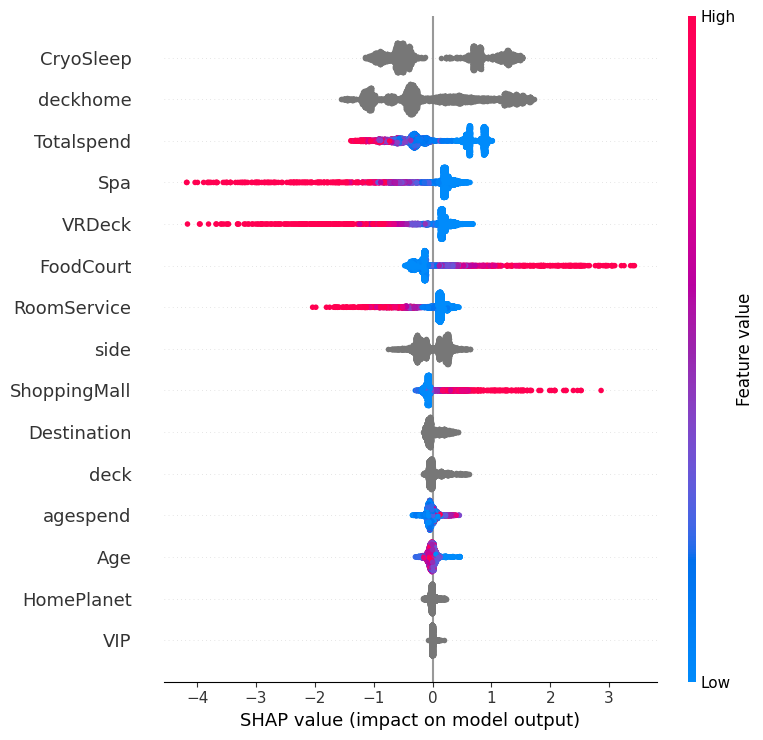

In [ ]:
import shap


explainer = shap.TreeExplainer(lgb_model, feature_perturbation="tree_path_dependent")

shap_values = explainer.shap_values(x_test)

# Visualisation
shap.summary_plot(shap_values, x_test)


22)
FR : Interprétation :
 La visualisation SHAP aurait classé par importance les colonnes CryoSleep, deckHome, TotalSpend comme les plus importantes pour le modèle. En conclusion, pour mon modèle, ces colonnes seront choisies en priorité pour la prédiction.

EN : Interpretation: 
SHAP visualization would rank CryoSleep, deckHome, and TotalSpend as the most important columns for the model. In conclusion, for my model, these columns will be prioritized for prediction.

In [ ]:
#Final prediction
final_prediction=lgb_model.predict(x_test)

In [ ]:
#save test prediction to file  and submission 
output=pd.DataFrame({"PassengerId":test_ids,"Transported":final_prediction}) 
output.to_csv("submission.csv",index=False)
#output

English version

To improve my results, I plan to increase the number of combined and innovative features.

Handle missing values until there are absolutely none left.

Apply skew transformations to numerical columns when necessary.

Test target encoding with KFold on categorical columns that have high cardinality.

Encode features intelligently depending on their type — ordinal or nominal.

For nominal columns that show an ordinal relationship with the target, I’ll create new ordinal features.
Finally, if my score plateaus around 0.85, I’ll build a model ensemble.
You can check the ensemble I built on the House Prices Advanced competition — for now, I’ll just keep having fun exploring Kaggle datasets.

🇫🇷 Version française

Pour améliorer mes résultats, je prévois d’augmenter le nombre de features combinées et innovantes.

Gérer les valeurs manquantes jusqu’à ce qu’il n’en reste plus aucune.

Appliquer une transformation de skewness sur les colonnes numériques lorsque c’est nécessaire.

Tester un target encoding couplé à un KFold sur les colonnes catégorielles à forte cardinalité.

Encoder les variables intelligemment selon leur nature — ordinale ou nominale.

Pour les colonnes nominales ayant une relation ordinale avec la cible, je créerai une feature ordinale.
Enfin, si mon score plafonne autour de 0,85, je mettrai en place un assemblage de modèles.
Vous pouvez voir l’assemblage que j’ai réalisé sur House Prices Advanced(Dans 1 jour) ; pour l’instant, je continue à m’amuser sur les jeux de données Kaggle.